In [1]:
monitor='val_accuracy'
epochs=90
batch_size=32
input_shape=(224, 224, 3) # please resize it to (224,224,3) if you have enough RAM
Verbose=True

In [2]:
import sys
print("Python version:", sys.version)

import skimage
print('skimage:',  skimage.__version__)

import tensorflow as tf
print('Tensorflow:',tf.__version__)

import cai
import cai.datasets
import cai.models

import multiprocessing
import os

from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Python version: 3.9.18 (main, Sep  7 2023, 00:00:00) 
[GCC 11.4.1 20230605 (Red Hat 11.4.1-2)]
skimage: 0.22.0
Tensorflow: 2.15.0


In [3]:
data_dir = "/home/hamid/Project/DataSets/Apple-Leaf-diseases-13classes"

label_of_classes = os.listdir(data_dir)
print("Classes Lables:", label_of_classes)

number_of_classes = len(label_of_classes)
print("Number of Classes:", number_of_classes)

Classes Lables: ['Alternaria Leaf Spot', 'Apple rot', 'Apple Scab', 'Block rot', 'Brown Spot', 'Cedar apple rust', 'Frogeye Leaf Spot', 'Grey Spot', 'Healthy', 'Leaf Blotch', 'Mosaic', 'Powdery Mildew', 'Rust']
Number of Classes: 13


In [4]:
train_x, val_x, test_x, train_y, val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(
    seed=7,
    root_dir=data_dir,
    lab=True,
    verbose=Verbose,
    bipolar=False,
    base_model_name='apple13_leaf',
    training_size=0.6,
    validation_size=0.2,
    test_size=0.2,
    target_size=(input_shape[0],input_shape[1]),
    has_training=True,
    has_validation=True,
    has_testing=True,
    smart_resize=True
)

Loading  13  classes.
smart resize is enabled.
loading train images
train shape is: (3516, 224, 224, 3)
loading validation images
validation shape is: (1171, 224, 224, 3)
loading test images
test shape is: (1180, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 0.8897463
Channel  2  min: 0.0  max: 0.96785784
Loaded.


In [5]:
print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

(3516, 224, 224, 3) (1171, 224, 224, 3) (1180, 224, 224, 3)
(3516, 13) (1171, 13) (1180, 13)


In [6]:
all_history = []
epochs=1
for two_paths_second_block in [False, True]:
    for l_ratio in [0.1]:  # [0.1,0.3,0.5,0.7,0.9]:
        
        basefilename = 'Apple13-twoPath-inception-' + str(two_paths_second_block) + '-' + str(l_ratio)
        print('Running: '+basefilename)
          
        model = cai.models.compiled_two_path_inception_v3(
            input_shape=input_shape, 
            classes=number_of_classes,
            two_paths_partial_first_block=5,
            two_paths_first_block=True,
            two_paths_second_block=two_paths_second_block,
            l_ratio=l_ratio,
            ab_ratio=(1-l_ratio),
            max_mix_idx=3, 
            model_name='two_path_inception_v3'
        )
          
        best_result_file_name = basefilename+'-best_result.keras'
          
        save_best = tf.keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name, 
            monitor=monitor, 
            verbose=1,
            save_best_only=True,
            save_weights_only=False, 
            mode='max',
            save_freq='epoch'
        )
          
        history = model.fit(
            train_x,
            train_y, 
            epochs=epochs, 
            batch_size=batch_size,
            validation_data=(val_x,val_y),
            callbacks=[save_best],
            class_weight=classweight,
            workers=multiprocessing.cpu_count()
        )

        all_history.append(history)
          
        print('Testing Last Model: '+basefilename)
          
        evaluated = model.evaluate(test_x,test_y)
          
        for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
            print(name,metric)
            
        print('Best Model Results: '+basefilename)
          
        model = tf.keras.models.load_model(
            best_result_file_name,
            custom_objects={'CopyChannels': cai.layers.CopyChannels}
        )
          
        evaluated = model.evaluate(test_x,test_y)
          
        cai.models.save_model(model, basefilename)
          
        for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
          print(name,metric)
        
        print('Finished: '+basefilename)

Running: Apple13-twoPath-inception-False-0.1


2024-01-13 11:39:46.693671: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2117025792 exceeds 10% of free system memory.


110/110 [==============================] - ETA: 0s - loss: 0.9235 - accuracy: 0.6729

2024-01-13 11:47:26.900470: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 705073152 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.09052, saving model to Apple13-twoPath-inception-False-0.1-best_result.keras
110/110 [==============================] - 494s 4s/step - loss: 0.9235 - accuracy: 0.6729 - val_loss: 3.8256 - val_accuracy: 0.0905
Testing Last Model: Apple13-twoPath-inception-False-0.1


2024-01-13 11:48:03.004365: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 710492160 exceeds 10% of free system memory.


37/37 [==============================] - 34s 928ms/step - loss: 3.8466 - accuracy: 0.0788
loss 3.8466272354125977
acc 0.07881356030702591
Best Model Results: Apple13-twoPath-inception-False-0.1


2024-01-13 11:48:47.362586: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 710492160 exceeds 10% of free system memory.


37/37 [==============================] - 33s 877ms/step - loss: 3.8466 - accuracy: 0.0788
loss 3.8466272354125977
acc 0.07881356030702591
Finished: Apple13-twoPath-inception-False-0.1
Running: Apple13-twoPath-inception-True-0.1


2024-01-13 11:49:34.414606: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2117025792 exceeds 10% of free system memory.


110/110 [==============================] - ETA: 0s - loss: 0.9933 - accuracy: 0.6470
Epoch 1: val_accuracy improved from -inf to 0.10675, saving model to Apple13-twoPath-inception-True-0.1-best_result.keras
110/110 [==============================] - 505s 5s/step - loss: 0.9933 - accuracy: 0.6470 - val_loss: 4.3361 - val_accuracy: 0.1067
Testing Last Model: Apple13-twoPath-inception-True-0.1
37/37 [==============================] - 33s 868ms/step - loss: 4.3302 - accuracy: 0.1085
loss 4.330193519592285
acc 0.10847457498311996
Best Model Results: Apple13-twoPath-inception-True-0.1
37/37 [==============================] - 35s 918ms/step - loss: 4.3302 - accuracy: 0.1085
loss 4.330193519592285
acc 0.10847457498311996
Finished: Apple13-twoPath-inception-True-0.1


In [7]:
print(all_history)

[<keras.src.callbacks.History object at 0x7f09e0572760>, <keras.src.callbacks.History object at 0x7f09dbe54700>]


In [8]:
def plot_history(history):
    
    plt.figure(figsize=(10, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.ylim(top=5, bottom=0)

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.savefig('tomatom-leaf-mix-10-loss-acc.png')

    plt.tight_layout()
    plt.show()

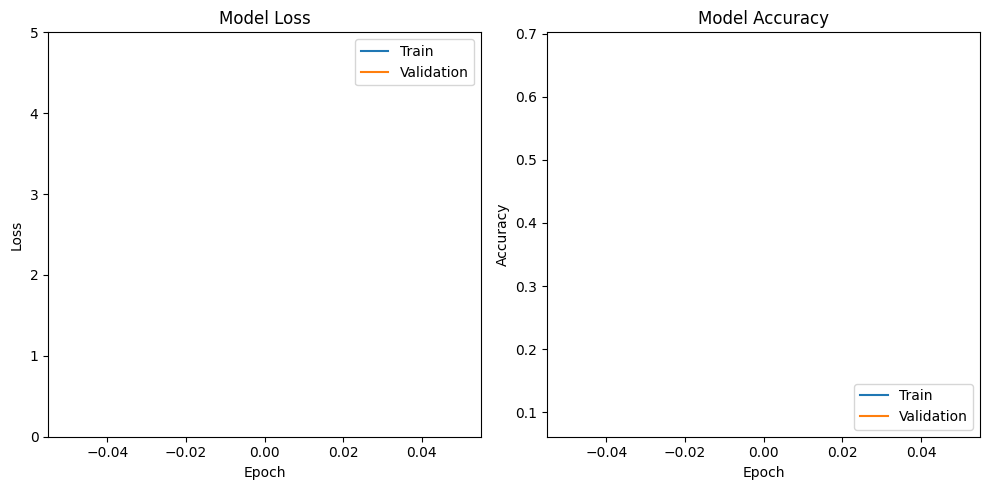

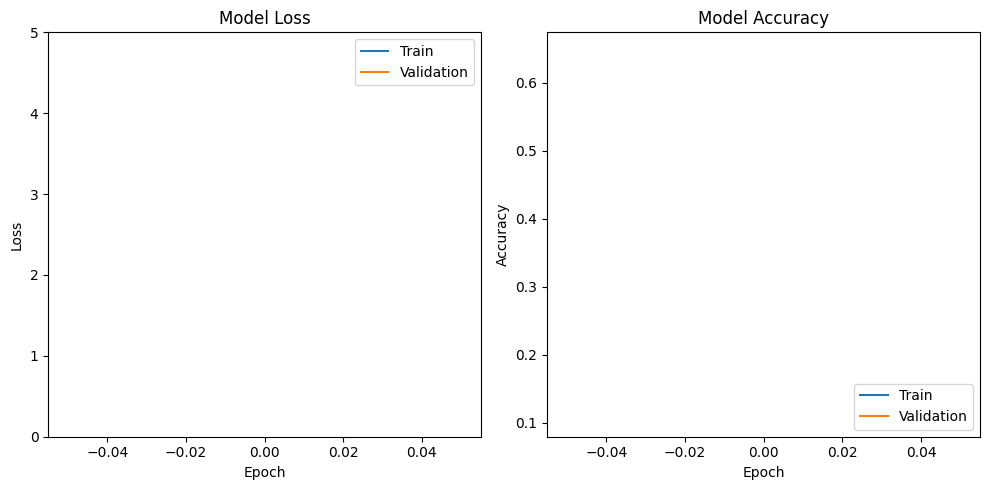

IndexError: list index out of range

In [9]:
for i in [0,1,2]:
    plot_history(all_history[i])

In [ ]:
model = tf.keras.models.load_model(
            'Apple13-twoPath-inception-0.2-best_result.keras',
            custom_objects={'CopyChannels': cai.layers.CopyChannels}
        )
evaluated = model.evaluate(test_x,test_y)       
          
for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
    print(name,metric)
            
# Make predictions
y_pred_prob = model.predict(test_x)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_y, axis=1), y_pred)

In [ ]:
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes_labels, yticklabels=classes_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model = tf.keras.models.load_model(
            'Apple13-twoPath-inception-0.5-best_result.keras',
            custom_objects={'CopyChannels': cai.layers.CopyChannels}
        )
evaluated = model.evaluate(test_x,test_y)       
          
for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
    print(name,metric)
            
# Make predictions
y_pred_prob = model.predict(test_x)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_y, axis=1), y_pred) 

In [ ]:
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes_labels, yticklabels=classes_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model = tf.keras.models.load_model(
            'Apple13-twoPath-inception-0.8-best_result.keras',
            custom_objects={'CopyChannels': cai.layers.CopyChannels}
        )
evaluated = model.evaluate(test_x,test_y)       
          
for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
    print(name,metric)
            
# Make predictions
y_pred_prob = model.predict(test_x)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_y, axis=1), y_pred) 

In [ ]:
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes_labels, yticklabels=classes_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()